In [1]:
import numpy as np
import pandas as pd
import os
import torchvision
import torch
import torch.nn as nn
from torchvision.models import resnet101
from torch.utils.data import DataLoader,Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms  as transforms
from PIL import Image
import torch.optim as optim
from torch.optim import lr_scheduler
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
IMG_DIR = '/media/user/New Volume/AliveDataset/ISIC_Datasets/SIIM-ISIC-2020/train'

csv_path = '/media/user/New Volume/AliveDataset/ISIC_Datasets/SIIM-ISIC-2020/train.csv'

In [3]:


df = pd.read_csv(csv_path) #(33126, 8)
 
# Spliting into Training and Validation 8:2 ration
train_df = df.sample(frac=0.8,random_state=222) # (26501, 8)
train_df.reset_index(inplace=True)

valid_df = df.drop(train_df.index) # (6625, 8)
valid_df.reset_index(inplace=True) 

In [4]:
train_df['benign_malignant'].value_counts()

benign_malignant
benign       26029
malignant      472
Name: count, dtype: int64

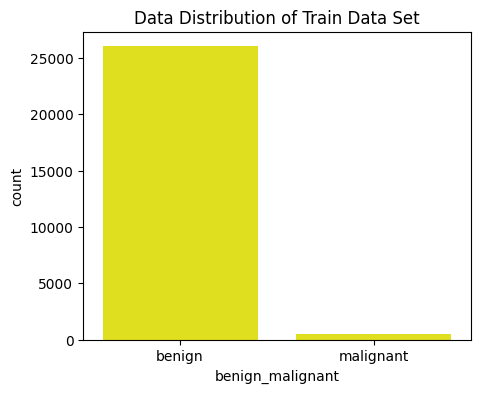

In [5]:
plt.figure(figsize=(5,4))
sns.barplot(data=train_df['benign_malignant'].value_counts(),color='Yellow')
plt.title('Data Distribution of Train Data Set')
plt.show()

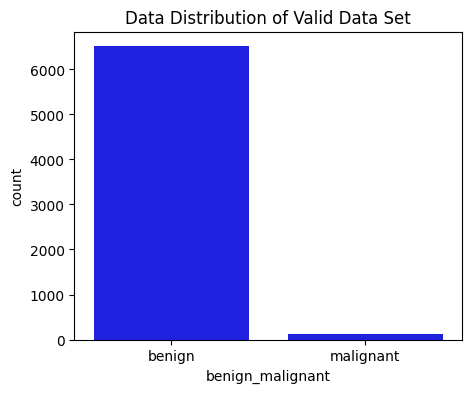

In [6]:
plt.figure(figsize=(5,4))
sns.barplot(data=valid_df['benign_malignant'].value_counts(),color='Blue')
plt.title('Data Distribution of Valid Data Set')
plt.show()

In [7]:
len(df['target'].unique())

2

In [8]:
torch.eye(2)[df['target']][1]

tensor([1., 0.])

In [9]:
df.loc[5]

image_name                          ISIC_0074311
patient_id                            IP_2950485
sex                                       female
age_approx                                  40.0
anatom_site_general_challenge    lower extremity
diagnosis                                unknown
benign_malignant                          benign
target                                         0
Name: 5, dtype: object

In [10]:
class SkinCancerDataset(Dataset):
    def __init__(self,dataframe,transforms):
        super().__init__()
        self.data = dataframe
        self.transforms = transforms
        self.labels = torch.eye(len(self.data['target'].unique()))[self.data['target']]

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):

        image_path = os.path.join(IMG_DIR,self.data.iloc[index]['image_name']+'.jpg')
        image  = Image.open(image_path)
        image = self.transforms(image)
        label = torch.tensor(self.data.iloc[index]['target'])

        return {'images':image,'labels':label}
    
    

In [11]:
train_transformations  = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.RandomHorizontalFlip(p=0.2),
                                       transforms.RandomRotation(degrees=(-5,5)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485,0.456,0.406],
                                                            std=[0.229,0.224,0.225])])



val_transformations  = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485,0.456,0.406],
                                                            std=[0.229,0.224,0.225])])


In [12]:
train_dataset = SkinCancerDataset(train_df,train_transformations)
val_dataset = SkinCancerDataset(valid_df,val_transformations)

In [13]:


train_sampler = SubsetRandomSampler(train_df.index.to_list())
valid_sampler = SubsetRandomSampler(valid_df.index.to_list())

In [14]:
train_loader = DataLoader(train_dataset,batch_size=32,sampler=train_sampler)
valid_loader = DataLoader(train_dataset,batch_size=32,sampler=valid_sampler)

In [15]:
for d in train_loader:
    img = d['images']
    label = d['labels']
    # break
    print(label)
    break


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1975338].


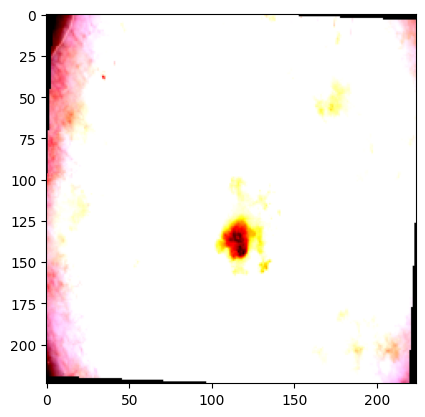

In [16]:
import matplotlib.pyplot as plt
#Visualize
idx = 1
image = np.transpose(img[idx].numpy(),(1,2,0))

plt.imshow(image)

In [17]:
model = resnet101(pretrained=True)


for param in model.parameters():
    param.requires_grad_ = False


# Add a new final layer
num_filters = model.fc.in_features
model.fc = nn.Linear(num_filters,2)

model = model.to(device=device)

/home/user/miniforge3/envs/Exp/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/miniforge3/envs/Exp/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
lr_sch = lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)

In [19]:
def train_epoch(trainLoader,model,optimizer,criteria,scheduler):
    model.train()

    total = 0
    correct = 0

    train_losses = []
    for batch_idx,d in enumerate(trainLoader):
        data = d['images'].to(device)
        target = d['labels'].to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criteria(output,target)
        loss.backward()

        optimizer.step()


        if batch_idx % 20==0:
            print(f'Training Loss at {batch_idx} --> {loss.item()}')
            

        train_losses.append(loss.item())
        
        pred = output.data.max(1,keepdim=True)[1] # Getting the indices of prediction

        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())

        total +=1

    return correct,total,train_losses



        


In [20]:
def val_epoch(valLoader,model,criteria):

    model.eval()

    total = 0
    correct = 0
    valid_losses = []
    for batch_idx ,d in enumerate(valLoader):
            data = d['images'].cuda()
            target = d['labels'].cuda()
            
            output = model(data)
            loss = criteria(output,target)
            
            
            if batch_idx%20==0:
                print('Validation_loss {}'.format(loss.item()))
            pred = output.data.max(1,keepdim=True)[1]
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total+=data.size(0)


            valid_losses.append(loss.item())
    return correct,total,valid_losses


    

In [23]:
earlyStop = EarlyStopping()

In [24]:
def ModelTraining(epochs,model,optimizer,criteria,scheduler):

    avg_train_loss = []
    avg_val_loss = []

    for epoch in range(epochs):
        correctTrain,totalTrain,trainLosses = train_epoch(train_loader,model,optimizer,criteria,scheduler)
        correctVal,totalVal,valLosses = val_epoch(valid_loader,model,criteria)

        print(f'Epoch {epoch} | Train Accuracy {(correctTrain/totalTrain)*100} | ValidAccuracy {(correctVal/totalVal)* 100}')
        
        train_loss = np.average(trainLosses)
        valid_loss = np.average(valLosses)

        avg_train_loss.append(train_loss)
        avg_val_loss.append(valid_loss)

        earlyStop(valid_loss,model)

        if earlyStop.early_stop:
            print('Early Stopping')
            break
        scheduler.step()

    model.load_state_dict(torch.load('checkpoint.pt'))

    return model,avg_train_loss,avg_val_loss

        

In [25]:
#https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [26]:
model,training_losses,valid_losses = ModelTraining(epochs=100,model=model,optimizer=optimizer,criteria=criteria,scheduler=lr_sch)

Training Loss at 0 --> 0.83199542760849
Training Loss at 20 --> 0.19216708838939667
Training Loss at 40 --> 0.009795427322387695
Training Loss at 60 --> 0.0073853288777172565
Training Loss at 80 --> 0.003161392407491803
Training Loss at 100 --> 0.032334104180336
Training Loss at 120 --> 0.018422609195113182
Training Loss at 140 --> 0.12373179197311401
Training Loss at 160 --> 0.023701587691903114
Training Loss at 180 --> 0.12824207544326782
Training Loss at 200 --> 0.011074884794652462
Training Loss at 220 --> 0.27838408946990967
Training Loss at 240 --> 0.01133724395185709
Training Loss at 260 --> 0.1678207814693451
Training Loss at 280 --> 0.0168367438018322
Training Loss at 300 --> 0.03505140170454979


In [ ]:
pred  = model(img.to(device)).data.max(1)[1]

In [ ]:
pred_saved  = saved_model(img.to(device)).data.max(1)[1]

In [ ]:
pred_saved

In [ ]:
pred

In [ ]:
label

In [ ]:
print(label.data.view_as(pred))

In [ ]:
print(model)

In [ ]:
torch.save(model,'finetunedResnet.pt')

In [ ]:
saved_model = torch.load('/home/user/Documents/Alive/Alive_Repo/BaseLineModels/IRSoftAttention/finetunedResnet.pt')

In [ ]:
saved_model.eval()